## MAE290B, Final Project
## Cesar B. Rocha (<crocha@ucsd.edu>)
### Winter 2015

In [1105]:
from __future__ import division
import numpy as np
from numpy import sqrt,pi,cos,sin,exp,sinh
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 25, 'legend.handlelength'  : 2.5})


import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=3., rc={"lines.linewidth": 1.5})
sns.set_style("darkgrid",{'grid_color':.95})

###Computing the source term
\begin{equation}
q(y) = q_0 \text{e}^{-a(j\,\Delta y - l_y/2)^2}\,,\tag{1}
\end{equation}
<p></p>
where $j=1,2,\ldots,N-1$

In [170]:
def source(q0=.1,a=10,ly=2.,N=10): 
    """ computes the source term as a function of y 
        
        Paramaters
        -------------------------------------------
        q0 :: the strengths of the source
        a  :: decay scale
        ly :: length of box in y direction
        N  :: number of points for discretization
        
    """
    dy = 2/N
    return q0*exp(-a*(np.arange(1,N)*dy-ly/2.)**2)

###The initial condition is trivial
\begin{equation}
f(y,t=0) = 0,\,\, y\neq 0\,.\tag{2}
\end{equation}

In [216]:
def initial(N): 
    """ returns trivial initial conditions
    """
    return np.zeros(N-1)

### Now we compute the function that defines the right-hand-sind of the system of ODEs

In [427]:
def rhs_diff_source(f,q,dy,f0=4,fly=0.,lx=2,ly=2,N=10,k=1.,alpha=.01):
    
    """ computes the rhs of the system of ODEs  
        
        Paramaters
        -------------------------------------------
        f0  :: boundary condition at y = 0
        fly :: boundary condition at y = ly
        dy  :: grid resolution
        lx  :: length of box in x direction
        ly  :: length of box in y direction
        N   :: number of points for discretization
        
        Inputs
        -------------------------------------------
        f :: a N by 1 array with the function f 
                at nodes j=1,2,...,N
        q :: N by 1 array with the source term        
        
    """
    
    assert f.size == N-1, "function f must have size N-1"
    assert q.size == N-1, "the source array must have size N-1"
    
    # compute constants
    beta = alpha/dy**2
    gamma = alpha*4*(pi**2)*(k**2)/lx**2
    
    # append boundary conditions
    fn = f.copy()
    fn = np.append(f0,fn)
    fn = np.append(fn,fly)
        
    return beta*(fn[2:]+fn[0:-2]) - (2*beta+gamma)*fn[1:-1] + q

### We then adapt a previous code to  step this system of ODEs forward using RK3

In [451]:
def my_ode(F,f0,q,t0,tf,dt,dy,N=10,alpha=0.01,steady=True,Nmax=100000,tol=1.e-14,debug=False):
    
    '''
        Solve the system of ODEs that results from discretizing the
            two-dimensional diffusion equation with source q
            in a periodic domain in x.
            
        Parameters
        ---------------------------------------------------------
            t0: inital time
            tf: final time
            dt: time step
            N:  number of poins 
            
        Inputs    
        ----------------------------------------------------------
        F  :: function that represents the RHS of the system
        f0 :: N by 1 array of initial condition
    '''

    if steady:
        
        fnew = f0.copy()
        
        for i in range(Nmax):
            
            fold = fnew.copy()
            fnew =  stepforward(F,fold,q=q,dt=dt,dy=dy,N=N)
            if np.std(np.abs(fnew-fold))<tol:
                break
        
        if debug and (i<Nmax-1):
            print "Converged to steady state after %i time-steps" %(i+1)        
            print "The error after %i time-steps is %e" %(i+1,np.std(np.abs(fnew-fold)))
        else:
            print "Did not converge to steady state after %i time-steps" %(i+1)        
            print "The error after %i time-steps is %e" %(i+1,np.std(np.abs(fnew-fold))) 
        
        return fnew
        
    else:
        
        t = np.arange(t0,tf+dt,dt)
    
        fs = np.zeros((N-1,t.size))
        fs[:,0] = f0
    
        for i in range(1,t.size):
            fs[:,i] = stepforward(F,fs[:,i-1],q=q,dt=dt,dy=dy,N=N)

        return fs,t

def stepforward(F,f,q,dt,dy,alpha=alpha,N=10):
    
    '''
            Steps forward of ODEs that results from discretizing the
            two-dimensional diffusion equation with source q
            in a periodic domain in x.
            
            Uses RK3 schemme    
          
    '''
    
    a1 = 8/15.
    a2 = 2/3.

    F1 = F(f,q,dy,N=N,alpha=alpha)
    f1 = f + dt*a1*F1

    F2 = F(f1,q,dy,N=N,alpha=alpha)
    f2 = f1 + dt*a2*F2

    F3 = F(f2,q,dy,N=N,alpha=alpha)
    fnew = f + dt/4.*(F1+3.*F3)

    return fnew

In [1340]:
k = 1.
lx,ly = 2,2
alpha = 0.01
    
N = 10
lx,ly = 2.,2.
dy = 2/N
y = np.arange(dy,ly+dy,dy)

beta = 4*alpha/dy**2
gamma = alpha*((2*pi*k)**2)/(lx**2)

# calculate dt that guarantees stability
dt = 0.45*2.5127/(beta + gamma) 
print "the estimated time-step is  %e" %dt

the estimated time-step is  1.029143e+00


### Now integrate the equation: $q_0 = -0.04,\,0,\,0.04$

In [1341]:
q0 = np.array([-0.04,0.,0.04])
f0 = initial(N)
f = np.empty((q0.size,N-1))


for i in range(q0.size):
    print "Calculating solution with q0 =  %f" %q0[i]
    q = source(q0=q0[i],a=10,ly=2.,N=N)
    f[i,:] = my_ode(rhs_diff_source,f0,q,0,5,dt,dy,N=N,alpha=alpha,steady=True,debug=True)
    print " "

Calculating solution with q0 =  -0.040000
Converged to steady state after 232 time-steps
The error after 232 time-steps is 9.174177e-15
 
Calculating solution with q0 =  0.000000
Converged to steady state after 235 time-steps
The error after 235 time-steps is 9.677999e-15
 
Calculating solution with q0 =  0.040000
Converged to steady state after 238 time-steps
The error after 238 time-steps is 9.077374e-15
 


### Compute the solution $T\left(x,y=\tfrac{l_y}{2}\right) = f\left(\tfrac{l_y}{2}\right)\,\sin\left(\tfrac{2\pi\,k\,x}{l_x}\right)$

In [1308]:
x = np.linspace(0,lx,100)
T = np.array(np.matrix(f[:,N/2]).T*np.matrix(np.sin(2*pi*k*x/lx)))

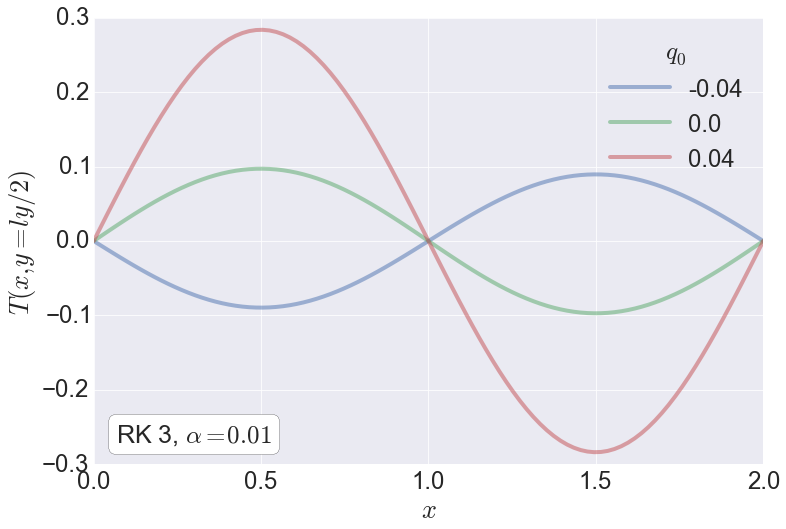

In [1345]:
lw,aph = 4.,.5

fig=plt.figure(figsize=(12,8))
plt.plot(x,T[0,:],label=str(q0[0]),linewidth=lw,alpha=aph)
plt.plot(x,T[1,:],label=str(q0[1]),linewidth=lw,alpha=aph)
plt.plot(x,T[2,:],label=str(q0[2]),linewidth=lw,alpha=aph)
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x,y=ly/2)$')
plt.legend(loc=1, title = r"$q_0$")
plt.text(0.3, -.26, r"RK 3, $\alpha = 0.01$", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
plt.savefig('T_rk3.eps')

In [892]:
-

def test_thomas(ns=100):
    
    """ test my implementation Thomas algorithm  """

    from scipy import sparse        # to define sparse matrices
    
    ud,md,ld = np.random.rand(ns), np.random.rand(ns), np.random.rand(ns)

    M = sparse.spdiags([ld,md,ud], [-1,0,1],ns,ns,format='csr')
    rhs = np.random.randn(ns)
    
    x_my = Thomas(md,ld[0:-1],ud[1:],rhs)
    x_sp = sparse.linalg.spsolve(M,rhs)

    assert np.allclose(x_sp,x_my), "My Thomas algorithm failed"   
    
    print "My Thomas is working just fine!"
    

### Employing CN, we need to solve a symmetric tridiagonal system every time-step

In [1139]:
# testing my thomas algorithm
test_thomas()

My Thomas is working just fine!


In [1272]:
def my_ode_cn(f0,q,t0,tf,dt,dy,N=10,k=1.,lx=2.,ly=2.,alpha=0.01,steady=True,Nmax=100000,tol=1.e-14,debug=False):
    
    '''
        Solve the system of ODEs that results from discretizing the
            two-dimensional diffusion equation with source q
            in a periodic domain in x.
            
        Parameters
        ---------------------------------------------------------
            t0: inital time
            tf: final time
            dt: time step
            N:  number of poins 
            
        Inputs    
        ----------------------------------------------------------
        f0 :: N by 1 array of initial condition
        q  :: N by 1 arrat with the source
    '''
    
    # compute constants
    beta = alpha/dy**2
    gamma = alpha*4*(pi**2)*(k**2)/lx**2

    xi_m = 1. - dt*beta - gamma*dt/2.    
    xi_lu =  dt*beta/2    
        
    # compute coefficients of tridiagonal matrix
    a = (1+ dt*beta + gamma*dt/2)*np.ones(N-1)    # main diagonal    
    b = -dt*beta/2*np.ones(N-2) 
    c = np.copy(b)
    
    if steady:
  
        fnew = f0.copy()
        
        for i in range(Nmax):
            
            fold = fnew.copy()
            
            # compute the rhs
            rhs = np.empty(N-1)
            rhs[1:-1] = xi_lu*fold[0:-2] + xi_m*fold[1:-1] + xi_lu*fold[2:] + q[1:-1]
            
            # special boundary cases: note that python indexing always starting from 0
            rhs[0] = 4*dt*beta + xi_m*fold[0] + xi_lu*fold[1] + q[0]
            rhs[-1] = xi_lu*fold[N-3] + xi_m*fold[N-2] + q[-1]
                        
            fnew = Thomas(a,b,c,rhs)
            
            if np.std(np.abs(fnew-fold))<tol:
                break
        
        if debug and (i<Nmax-1):
            print "Converged to steady state after %i time-steps" %(i+1)        
            print "The error after %i time-steps is %e" %(i+1,np.std(np.abs(fnew-fold)))
        else:
            print "Did not converge to steady state after %i time-steps" %(i+1)        
            print "The error after %i time-steps is %e" %(i+1,np.std(np.abs(fnew-fold))) 
        
        return fnew
        
    else:
        
        t = np.arange(t0,tf+dt,dt)
    
        fs = np.zeros((N-1,t.size))
        fs[:,0] = f0
    
        for i in range(1,t.size):
                        
            fold = fnew.copy()
            
            # compute the rhs
            rhs = np.empty(N-1)
            rhs[1:-1] = xi_lu*fold[0:-2] + xi_m*fold[1:-1] + xi_lu*fold[2:] + q[1:-1]
            
            # special boundary cases: note that python indexing always starting from 0
            rhs[0] = 4*dt*beta + xi_m*fold[0] + xi_lu*fold[1] + q[0]
            rhs[-1] = xi_lu*fold[N-3] + xi_m*fold[N-2] + q[-1]      

            fnew = Thomas(a,b,c,rhs)

            fs[:,i] = fnew
        return fs,t




In [1315]:
N = 10
dy = 2./N
q0 = np.array([-0.04,0.,0.04])
fcn = np.empty((q0.size,N-1))
f0 = initial(N)
alpha=.01
dt = 1.
for i in range(q0.size):
    print "Calculating solution with q0 =  %f" %q0[i]
    q = source(q0=q0[i],a=10,ly=2.,N=N)
    fcn[i,:] = my_ode_cn(f0,q,0,5,dt,dy,N=N,alpha=alpha,steady=True,debug=True)
    print " "

Calculating solution with q0 =  -0.040000
Converged to steady state after 225 time-steps
The error after 225 time-steps is 9.723139e-15
 
Calculating solution with q0 =  0.000000
Converged to steady state after 229 time-steps
The error after 229 time-steps is 9.079902e-15
 
Calculating solution with q0 =  0.040000
Converged to steady state after 231 time-steps
The error after 231 time-steps is 9.425510e-15
 


In [1316]:
x = np.linspace(0,lx,100)
Tcn = np.array(np.matrix(fcn[:,N/2]).T*np.matrix(np.sin(2*pi*k*x/lx)))

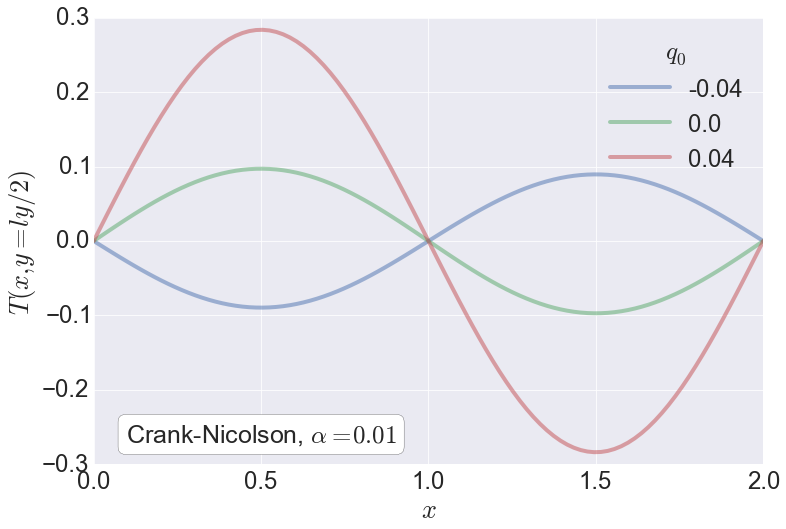

In [1317]:
fig=plt.figure(figsize=(12,8))
plt.plot(x,Tcn[0,:],label=str(q0[0]),linewidth=lw,alpha=aph)
plt.plot(x,Tcn[1,:],label=str(q0[1]),linewidth=lw,alpha=aph)
plt.plot(x,Tcn[2,:],label=str(q0[2]),linewidth=lw,alpha=aph)
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x,y=ly/2)$')
plt.legend(loc=1, title = r"$q_0$")
plt.text(0.5, -.26, r"Crank-Nicolson, $\alpha = 0.01$", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
plt.savefig('Tcn_y1.eps')

In [1347]:
fcn2 = np.empty((q0.size,N-1))
dt = 1.
alpha = 0.0001
for i in range(q0.size):
    print "Calculating solution with q0 =  %f" %q0[i]
    q = source(q0=q0[i],a=10,ly=2.,N=N)
    fcn2[i,:] = my_ode_cn(f0,q,0,5,dt,dy,N=10,alpha=alpha,steady=True,debug=True)
    print " "

Calculating solution with q0 =  -0.040000
Converged to steady state after 21863 time-steps
The error after 21863 time-steps is 9.685930e-15
 
Calculating solution with q0 =  0.000000
Converged to steady state after 19054 time-steps
The error after 19054 time-steps is 9.980096e-15
 
Calculating solution with q0 =  0.040000
Converged to steady state after 21848 time-steps
The error after 21848 time-steps is 9.988321e-15
 


In [1348]:
x = np.linspace(0,lx,100)
Tcn2 = np.array(np.matrix(fcn2[:,N/2]).T*np.matrix(np.sin(2*pi*k*x/lx)))

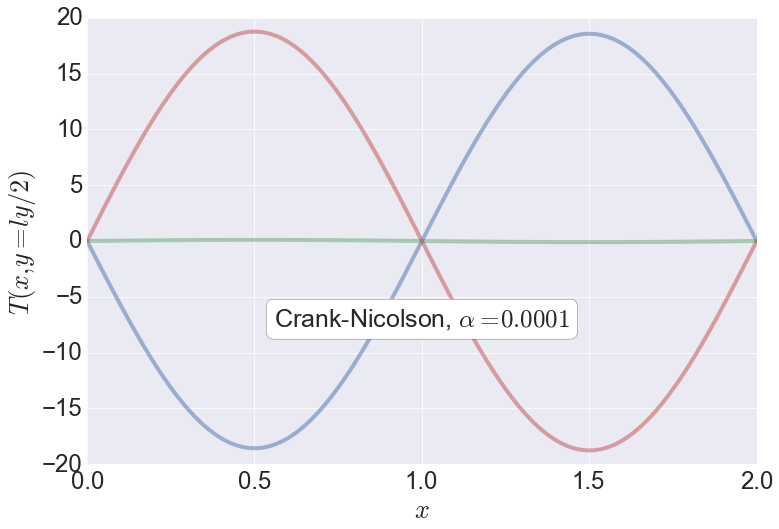

In [1353]:
fig=plt.figure(figsize=(12,8))
plt.plot(x,Tcn2[0,:],label=str(q0[0]),linewidth=lw,alpha=aph)
plt.plot(x,Tcn2[1,:],label=str(q0[1]),linewidth=lw,alpha=aph)
plt.plot(x,Tcn2[2,:],label=str(q0[2]),linewidth=lw,alpha=aph)
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x,y=ly/2)$')
plt.text(1., -7, r"Crank-Nicolson, $\alpha = 0.0001$", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
plt.savefig('Tcn2_y1.eps')

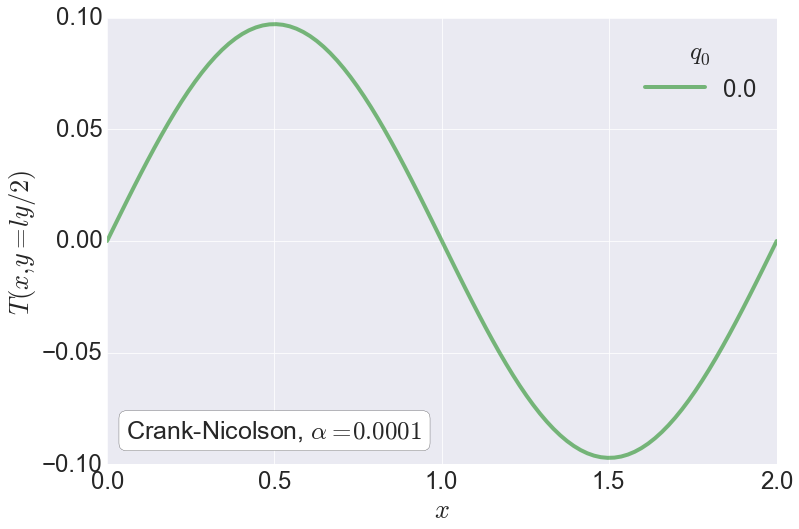

In [1352]:
fig=plt.figure(figsize=(12,8))
plt.plot(x,Tcn2[1,:],label=str(q0[1]),linewidth=lw,alpha=aph,color='g')
plt.xlabel(r'$x$')
plt.ylabel(r'$T(x,y=ly/2)$')
plt.legend(loc=1, title = r"$q_0$")
plt.text(.5, -.085, r"Crank-Nicolson, $\alpha = 0.0001$", size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
plt.savefig('Tcn2_green_y1.eps')

In [1290]:
# exact solution with q = 0
N = 10
dy = 2/N
A = 4/sinh(2*pi*k)
yi = np.arange(0,ly+dy,dy)
fexact = A*sinh(2*pi*k*(ly-yi)/lx) # exact solution with q = 0

# append boundary ccnditions
f0 = np.append(4.,f[1,:])
f0 = np.append(f0,0)

The RMS difference is 8.330878e-03


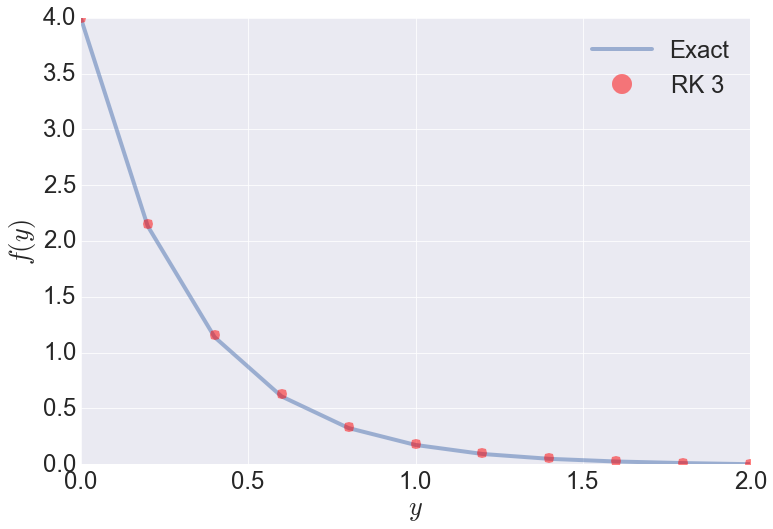

In [1292]:
fig=plt.figure(figsize=(12,8))
plt.plot(yi,fexact,label='Exact',linewidth=lw,alpha=aph)
plt.plot(yi,f0,'ro',markersize=10,alpha=aph,label='RK 3',)
plt.xlabel(r'$y$')
plt.ylabel(r'$f(y)$')
plt.legend(loc=1, title = r"")
plt.savefig('f_rk3_exact.eps')

np.allclose(f0,fexact)
print "The RMS difference is %e" %(fcn0-fexact).std()

### Now we experiment with different different resolution in y
 First we code a simple function to compute and plot the solution for various $N$ given the diffusivity $\alpha$ and the source strength $q_0

In [1253]:
Ns = np.array([5,10,50,100,200,500,1000])
x = np.linspace(0,lx,100)

In [1386]:
def compute_plot_soln(q0=0.04,alpha=0.001):
    
    #Ns = np.array([5,10,50,100,200,300,400,500])
    Ns = np.array([5,10,50,100,500])

    x = np.linspace(0,lx,100)
    
    
    fig=plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    fig2=plt.figure(figsize=(12,8))
    ax2 = fig2.add_subplot(111)

    for i in range(Ns.size):

        q = source(q0,a=10,ly=2.,N=Ns[i])
        f0 = initial(Ns[i])
        dt = 1.
        dy = 2/Ns[i]
        print "Calculating solution with N = %i,  q0 =  %f" %(Ns[i],q0)
        fcn_y = my_ode_cn(f0,q,0,5,dt,dy,N=Ns[i],alpha=alpha,steady=True,debug=True)
        print " "
        yi = np.arange(0,ly+dy,dy)
        fcn_y = np.append(4.,fcn_y)
        fcn_y = np.append(fcn_y,0)
    
        fig
        ax.plot(yi,fcn_y,linewidth=lw,alpha=aph,label=str(Ns[i]))
    
        fig2
        ax2.plot(x,np.array(fcn_y[Ns[i]/2])*np.sin(2*pi*k*x/lx)\
                 ,linewidth=lw,alpha=aph,label=str(Ns[i]))
    
        del fcn_y

    fig
    ax.set_xlabel(r'$y$')
    ax.set_ylabel(r'$f(y)$')
    ax.legend(loc=1, title = r"")
    ax.text(.95, 3.5, r"Crank-Nicolson, $\alpha =$" +str(alpha)+ ", $q_0=$"+str(q0), size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
    tit1 = "f_various_N_a" + str(int(alpha*1000))+"_q0"+str(int(q0*100))+".eps"
    plt.savefig(tit1,format="eps")
    plt.close()
    
    fig2
    ax2.set_xlabel(r'$x$')
    ax2.set_ylabel(r'$T(x,y=l_y/2)$')
    ax2.legend(loc=1, title = r"")
    ax2.text(.65, -3.35, r"Crank-Nicolson, $\alpha =$" +str(alpha)+ ", $q_0=$"+str(q0), size=25, rotation=0.,\
            ha="center", va="center",\
            bbox = dict(boxstyle="round",ec='k',fc='w'))
    tit2 = "T_various_N_a" + str(int(alpha*1000))+"_q0"+str(int(q0*100))+".eps"
    plt.savefig(tit2,format="eps")
    plt.close()

In [1387]:
compute_plot_soln(q0=0.04,alpha=0.01)

Calculating solution with N = 5,  q0 =  0.040000
Converged to steady state after 229 time-steps
The error after 229 time-steps is 9.627797e-15
 
Calculating solution with N = 10,  q0 =  0.040000
Converged to steady state after 231 time-steps
The error after 231 time-steps is 9.425510e-15
 
Calculating solution with N = 50,  q0 =  0.040000
Converged to steady state after 232 time-steps
The error after 232 time-steps is 9.529743e-15
 
Calculating solution with N = 100,  q0 =  0.040000
Converged to steady state after 701 time-steps
The error after 701 time-steps is 9.689936e-15
 
Calculating solution with N = 500,  q0 =  0.040000
Converged to steady state after 17033 time-steps
The error after 17033 time-steps is 9.920548e-15
 


In [1388]:
compute_plot_soln(q0=-0.04,alpha=0.01)

Calculating solution with N = 5,  q0 =  -0.040000
Converged to steady state after 223 time-steps
The error after 223 time-steps is 9.536644e-15
 
Calculating solution with N = 10,  q0 =  -0.040000
Converged to steady state after 225 time-steps
The error after 225 time-steps is 9.723139e-15
 
Calculating solution with N = 50,  q0 =  -0.040000
Converged to steady state after 226 time-steps
The error after 226 time-steps is 9.957027e-15
 
Calculating solution with N = 100,  q0 =  -0.040000
Converged to steady state after 701 time-steps
The error after 701 time-steps is 9.614326e-15
 
Calculating solution with N = 500,  q0 =  -0.040000
Converged to steady state after 17168 time-steps
The error after 17168 time-steps is 9.933985e-15
 


In [1389]:
compute_plot_soln(q0=0.0,alpha=0.01)

Calculating solution with N = 5,  q0 =  0.000000
Converged to steady state after 227 time-steps
The error after 227 time-steps is 9.076126e-15
 
Calculating solution with N = 10,  q0 =  0.000000
Converged to steady state after 229 time-steps
The error after 229 time-steps is 9.079902e-15
 
Calculating solution with N = 50,  q0 =  0.000000
Converged to steady state after 230 time-steps
The error after 230 time-steps is 9.174297e-15
 
Calculating solution with N = 100,  q0 =  0.000000
Converged to steady state after 701 time-steps
The error after 701 time-steps is 9.750208e-15
 
Calculating solution with N = 500,  q0 =  0.000000
Converged to steady state after 17006 time-steps
The error after 17006 time-steps is 9.918840e-15
 


### Validade the converge with the sourceless example ($q_0=0$)

In [1399]:
def compute_error(q0=0.0,alpha=0.01):
    """ Compute the relative error in f at y=ly/2 """

    Ns = np.array([5,10,50,100,200,300,400,500])

    x = np.linspace(0,lx,100)
    error = np.empty(Ns.size)
    
    for i in range(Ns.size):

        q = source(q0,a=10,ly=2.,N=Ns[i])
        f0 = initial(Ns[i])
        dt = 1.
        k = 1.
        dy = 2/Ns[i]
        print "Calculating solution with N = %i,  q0 =  %f" %(Ns[i],q0)
        fcn_y = my_ode_cn(f0,q,0,5,dt,dy,N=Ns[i],alpha=alpha,steady=True,debug=True)
        print " "

        # exact solution
        A = 4/sinh(2*pi*k)
        yi = np.arange(0,ly+dy,dy)
        fexact = A*sinh(2*pi*k*(ly-yi)/lx) # exact solution with q = 0

        yi = np.arange(0,ly+dy,dy)
        fcn_y = np.append(4.,fcn_y)
        fcn_y = np.append(fcn_y,0)
        
        # compute the relative error at y = l_y/2
        error[i] = np.abs((fexact[Ns[i]/2]-fcn_y[Ns[i]/2])/fexact[Ns[i]/2])
        
    return error,Ns

In [1400]:
error_f,Ns, = compute_error(q0=0.0,alpha=0.01)

Calculating solution with N = 5,  q0 =  0.000000
Converged to steady state after 227 time-steps
The error after 227 time-steps is 9.076126e-15
 
Calculating solution with N = 10,  q0 =  0.000000
Converged to steady state after 229 time-steps
The error after 229 time-steps is 9.079902e-15
 
Calculating solution with N = 50,  q0 =  0.000000
Converged to steady state after 230 time-steps
The error after 230 time-steps is 9.174297e-15
 
Calculating solution with N = 100,  q0 =  0.000000
Converged to steady state after 701 time-steps
The error after 701 time-steps is 9.750208e-15
 
Calculating solution with N = 200,  q0 =  0.000000
Converged to steady state after 2768 time-steps
The error after 2768 time-steps is 9.996647e-15
 
Calculating solution with N = 300,  q0 =  0.000000
Converged to steady state after 6195 time-steps
The error after 6195 time-steps is 9.908040e-15
 
Calculating solution with N = 400,  q0 =  0.000000
Converged to steady state after 10971 time-steps
The error after 10

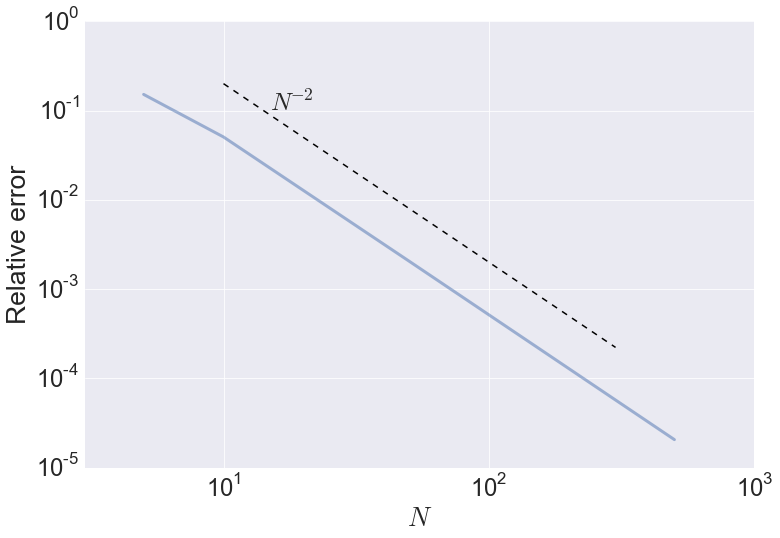

In [1414]:
ns = np.array([10,300])

fig=plt.figure(figsize=(12,8))
plt.loglog(Ns,error_f,linewidth=3,alpha=.5)
plt.loglog(ns,20./ns**2,'k--')
plt.text(15,.1,r'$N^{-2}$')
plt.xlabel(r'$N$')
plt.ylabel(r'Relative error')
plt.xlim(3,1000)
plt.savefig('error_cn.eps',format="eps")